# Bedrock Claude 및 LangGraph 를 이용한 Prompt Flow 

In [1]:
!python -V

Python 3.10.14


# 0. 환경 설정

In [2]:
%load_ext autoreload
%autoreload 2

import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)

module_path = "../.."
add_python_path(module_path)

python path: /home is added
sys.path:  ['/home/sagemaker-user/langgraph-demo', '/opt/conda/lib/python310.zip', '/opt/conda/lib/python3.10', '/opt/conda/lib/python3.10/lib-dynload', '', '/home/sagemaker-user/.local/lib/python3.10/site-packages', '/opt/conda/lib/python3.10/site-packages', '/home']


## Bedrock Client 생성

In [3]:
from pprint import pprint
from termcolor import colored
from utils import bedrock
from utils.bedrock import bedrock_info

boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: us-east-1
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1'

### 모델 ID 및 Bedrock converse API 정의

In [4]:
from utils.bedrock import *

# model_id = "anthropic.claude-3-sonnet-20240229-v1:0"
model_id = "anthropic.claude-3-5-sonnet-20240620-v1:0"



# 1. Graph 정의

#### 그래프 정의
- State 정의
- 그래프 빌더 정의
- 노드, 에지 정의
- 그래프 컴파일

In [5]:
!pip show pydantic

Name: pydantic
Version: 2.7.0
Summary: Data validation using Python type hints
Home-page: https://github.com/pydantic/pydantic
Author: 
Author-email: Samuel Colvin <s@muelcolvin.com>, Eric Jolibois <em.jolibois@gmail.com>, Hasan Ramezani <hasan.r67@gmail.com>, Adrian Garcia Badaracco <1755071+adriangb@users.noreply.github.com>, Terrence Dorsey <terry@pydantic.dev>, David Montague <david@pydantic.dev>, Serge Matveenko <lig@countzero.co>, Marcelo Trylesinski <marcelotryle@gmail.com>, Sydney Runkle <sydneymarierunkle@gmail.com>, David Hewitt <mail@davidhewitt.io>, Alex Hall <alex.mojaki@gmail.com>
License: 
Location: /opt/conda/lib/python3.10/site-packages
Requires: annotated-types, pydantic-core, typing-extensions
Required-by: amazon_sagemaker_jupyter_scheduler, anthropic, confection, fastapi, gluonts, jupyter_scheduler, langchain, langchain-core, langsmith, sagemaker-core, sagemaker-jupyterlab-extension-common, spacy, thinc, weasel


In [6]:
# # 템플릿 파일 기술
from utils.cross_region_inference_prompt_util import *

# 템플릿 파일의 경로를 지정
prompt_folder = "prompt_template"
outline_prompt_file_name = "outline_prompt_template.txt"

In [7]:
# # 프레젠테이션의 개요 생성 prompt template 로딩 및 토픽 추가

from jinja2 import Template

prompt_file_path = os.path.join(prompt_folder, outline_prompt_file_name)

template_content = load_template_from_file(prompt_file_path)
PROMPT_TEMPLATE = Template(template_content)

TOPIC = "2024년의 한국 부동산 시장 현황"
outline_prompt = PROMPT_TEMPLATE.render(topic=TOPIC)

print(outline_prompt)


You are an expert in creating impactful and professional PowerPoint presentations. 
Create a detailed outline for a 10-slide presentation in Korean, ensuring a logical flow and comprehensive coverage of the topic.

Analyze the given topic thoroughly to write in the provided <output_format> JSON format.
Return only the JSON object without additional tags or explanations.

<context>
2024년의 한국 부동산 시장 현황
</context>

<instruction>
1. Title:
   - Create a compelling and concise main title that captures the essence of the presentation.

2. Slides:
   - Generate 10 slides, including an opening and a closing slide.
   - For each slide:
     - Assign a slide_number (01 to 10).
     - Create a clear and informative slide_title.
     
3. Content Guidelines:
   - Ensure a logical flow and structure throughout the presentation.
   - Include an introduction slide (slide 02) and a conclusion slide (slide 09).   

4. Common Points:
   - Include the most important keywords related to the topic.
   - Ens

In [8]:
# # 슬라이드 내용 생성 prompt template 로딩

prompt_file_name = "slide_prompt_template.txt"

slide_prompt_file_path = os.path.join(prompt_folder, prompt_file_name)

template_content = load_template_from_file(slide_prompt_file_path)
slide_prompt_template = Template(template_content)
slide_prompt = slide_prompt_template.render()

print("\n## Slide prompt template...")
print(slide_prompt)


## Slide prompt template...
You are an expert in creating impactful and professional PowerPoint presentations.
Your task is to create detailed content for a specific slide in 10-slide presentation in Korean, ensuring a logical flow and comprehensive coverage of the topic.

Based on this  of the , Generate detailed content for slides  to .
For each slide, include:
1. Slide title
2. Main content points (3-5 bullet points)
3. Relevant data or examples
4. Suggesion for visuals (e.g., image, chart, graph)
5. A brief speaker note (1-2 sentences)


## 버전1: Aggregated graph - 프레젠테이션 1-5장, 6-10장 생성하는 노드 동시에 돌리기

[참고]
utils/bedrock.py의 converse_invoke를 쓰면 ThrottlingException이 발생했기 때문에 converse_invoke_with_backoff를 사용했음

에러 메시지: ThrottlingException: An error occurred (ThrottlingException) when calling the Converse operation (reached max retries: 10): Too many requests, please wait before trying again. You have sent too many requests.  Wait before trying again.

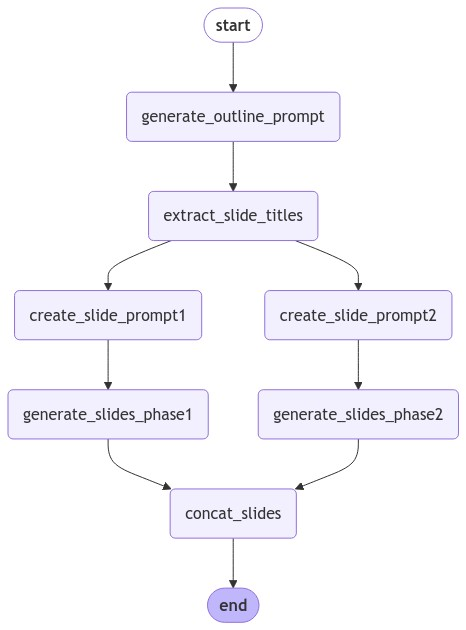

In [9]:
from typing import TypedDict, Annotated, Any
from langgraph.graph import StateGraph, START, END
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import HumanMessage
# from langgrpah.checkpoint.memory import MemorySaver
# import operator


# Stage 정의
class State(TypedDict):
    topic: Annotated[str, "프레젠테이션 주제"]
    outline_prompt: Annotated[str, "프레젠테이션 개요 생성을 위해 실행할 프롬프트"]
    outline: Annotated[str, "프레젠테이션 개요"]
    slide_titles: Annotated[list, "슬라이드 타이틀 모음"]
    slide_prompt1: Annotated[str, "슬라이드 내용 생성을 위해 실행할 프롬프트"]
    slide_prompt2: Annotated[str, "슬라이드 내용 생성을 위해 실행할 프롬프트"]
    response_phase1: Annotated[str, "슬라이드 1-5장 내용"]
    response_phase2: Annotated[str, "슬라이드 6-10장 내용"]
    completed_content: Annotated[str, "최종 생성된 프레젠테이션 내용"]
    # aggregate: Annotated[list, operator.add]
    

# class ReturnNodeValue:
#     def __init__(self, node_secret: str):
#         self._value = node_secret

#     def __call__(self, state: State) -> Any:
#         print(f"Adding {self._value} to {state['aggregate']}")
#         return {"aggregate": [self._value]}

# 프레젠테이션 개요 생성 노드 정의
def generate_outline_prompt(state: State) -> State:
    # llm = get_llm_model(model_id="claude-3-haiku-20240307):
    prompt = state["outline_prompt"]
    # response = converse_invoke(boto3_bedrock, model_id, prompt)  
    response = converse_invoke_with_backoff(boto3_bedrock, model_id, prompt)
    # print("response: \n", response)
    output_message = response['output']['message']['content'][0]['text']    
    # response = llm_sonnet.invoke([HumanMessage(content=prompt)])
    return State(outline=output_message)


# 생성한 프레젠테이션의 타이틀만 뽑아내는 노드 정의
def extract_slide_titles(state: State) -> State:
    # JSON 문자열을 Python 딕셔너리로 파싱
    outline = state["outline"]
    slide_titles = []
    data = json.loads(outline) if isinstance(outline, str) else outline
    # 메인 타이틀 출력
    # title = data['title']
    # 슬라이드 리스트를 순회하며 각 슬라이드의 제목 출력
    print("\n## Extract each slide titles in outline...")
    for slide in data['slides']:
        print(slide)
        slide_titles.append(slide['slide_title'])
    return State(slide_titles=slide_titles)


def create_slide_prompt1(state: State) -> State:
    print("\n## Generating prompt for creating the content of slides 1-5...\n")
    
    topic = state["topic"]
    outline = state["outline"]

    slide_prompt1 = slide_prompt_template.render(
        topic = topic,
        outline = outline,
        start_slide = 1,
        end_slide = 5
    )
    print("\n### Generated Prompt for slides 1-5...")
    print(slide_prompt1)
    return State(slide_prompt1=slide_prompt1)

def create_slide_prompt2(state: State) -> State:
    print("\n## Generating prompt for creating the content of slides 6-10...\n")
    
    topic = state["topic"]
    outline = state["outline"]

    slide_prompt2 = slide_prompt_template.render(
        topic = topic,
        outline = outline,
        start_slide = 6,
        end_slide = 10
    )
    print("\n### Generated Prompt for slides 6-10...")
    print(slide_prompt2)
    return State(slide_prompt2=slide_prompt2)

def generate_slides_phase1(state:State) -> State:
    slide_prompt1 = state["slide_prompt1"]
    print("\n## Generating content for slides 1-5...")
    

    
    # response1 = converse(boto3_bedrock, model_id, slide_prompt1)
    response1 = converse_invoke_with_backoff(boto3_bedrock, model_id, slide_prompt1)
    
    output_message1 = response1['output']['message']['content'][0]['text']
    print("\n### Generated content for slides 1-5...") 
    print(output_message1)
    return State(response_phase1=output_message1)


def generate_slides_phase2(state:State) -> State:
    slide_prompt2 = state["slide_prompt2"]
    print("\n## Generating content for slides 6-10...")
 

    
    # response2 = converse_invoke(boto3_bedrock, model_id, slide_prompt2)
    response2 = converse_invoke_with_backoff(boto3_bedrock, model_id, slide_prompt2)

    output_message2 = response2['output']['message']['content'][0]['text']
    print("\n### Generated content for slides 6-10...") 
    print(output_message2)
    return State(response_phase2=output_message2)

def concat_slides(state:State) -> State:
    response_phase1=state["response_phase1"]
    response_phase2=state["response_phase2"]
    merged_response = response_phase1 + response_phase2
    print("\n## Merged contents...")
    print(merged_response)
    return State(completed_content=merged_response)


# 그래프 정의
graph_builder = StateGraph(State)


# # 노드, 엣지 추가 
# graph_builder.add_node("generate_outline_prompt", generate_outline_prompt)
# graph_builder.add_edge(START, "generate_outline_prompt")
# graph_builder.add_node("extract_slide_titles", extract_slide_titles)
# graph_builder.add_edge("generate_outline_prompt", "extract_slide_titles")
# graph_builder.add_node("generate_slides_phase1", generate_slides_phase1)
# graph_builder.add_node("create_slide_prompt1", create_slide_prompt1)
# graph_builder.add_node("generate_slides_phase2", generate_slides_phase2)
# graph_builder.add_node("create_slide_prompt2", create_slide_prompt2)
# graph_builder.add_node("concat_slides", concat_slides)
# graph_builder.add_edge("extract_slide_titles","create_slide_prompt1")
# graph_builder.add_edge("extract_slide_titles","create_slide_prompt2")
# graph_builder.add_edge("create_slide_prompt1", "generate_slides_phase1")
# graph_builder.add_edge("create_slide_prompt2", "generate_slides_phase2")
# graph_builder.add_edge("generate_slides_phase1", "concat_slides")
# graph_builder.add_edge("generate_slides_phase2", "concat_slides")
# graph_builder.add_edge("concat_slides",END)


# Add nodes to the graph
graph_builder.add_node("generate_outline_prompt", generate_outline_prompt)
graph_builder.add_edge(START, "generate_outline_prompt")
graph_builder.add_node("extract_slide_titles", extract_slide_titles)
graph_builder.add_edge("generate_outline_prompt", "extract_slide_titles")
graph_builder.add_node("generate_slides_phase1", generate_slides_phase1)
graph_builder.add_node("create_slide_prompt1", create_slide_prompt1)
graph_builder.add_node("generate_slides_phase2", generate_slides_phase2)
graph_builder.add_node("create_slide_prompt2", create_slide_prompt2)
graph_builder.add_node("concat_slides", concat_slides)

# Define the flow of execution
graph_builder.add_edge("extract_slide_titles", "create_slide_prompt1")
graph_builder.add_edge("extract_slide_titles", "create_slide_prompt2")
graph_builder.add_edge("create_slide_prompt1", "generate_slides_phase1")
graph_builder.add_edge("create_slide_prompt2", "generate_slides_phase2")

# Ensure concat_slides runs only after both generate_slides_phase1 and generate_slides_phase2
graph_builder.add_edge("generate_slides_phase1", "concat_slides")
graph_builder.add_edge("generate_slides_phase2", "concat_slides")

# End the graph
graph_builder.add_edge("concat_slides", END)



# 그래프 컴파일
graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass



### 그래프를 실행할 함수 정의

In [10]:
def run_prompt(outline_prompt: str, topic: str, response_phase1: list, response_phase2: list, completed_content: list ):
    # inputs = {"prompt": prompt,"topic": topic}
    result = graph.invoke(State(outline_prompt=outline_prompt, topic=topic, response_phase1=response_phase1, response_phase2=response_phase1, completed_content=completed_content))
    # result = graph.invoke(input)
    return result["completed_content"]

### 그래프 실행

In [11]:
run_prompt(outline_prompt,TOPIC,[],[],[])


## Extract each slide titles in outline...
{'slide_number': '01', 'slide_title': '2024년 한국 부동산 시장: 현황과 전망'}
{'slide_number': '02', 'slide_title': '개요: 2024년 부동산 시장의 주요 특징'}
{'slide_number': '03', 'slide_title': '경제 지표와 부동산 시장의 상관관계'}
{'slide_number': '04', 'slide_title': '주택 시장 동향: 가격, 거래량, 주택 유형별 분석'}
{'slide_number': '05', 'slide_title': '상업용 부동산 시장: 오피스, 리테일, 물류 센터'}
{'slide_number': '06', 'slide_title': '정부 정책이 부동산 시장에 미치는 영향'}
{'slide_number': '07', 'slide_title': '부동산 투자 트렌드: 프롭테크와 리츠(REITs)'}
{'slide_number': '08', 'slide_title': '지역별 부동산 시장 분석: 수도권 vs 지방'}
{'slide_number': '09', 'slide_title': '결론: 2024년 한국 부동산 시장 전망'}
{'slide_number': '10', 'slide_title': 'Q&A 및 마무리'}

## Generating prompt for creating the content of slides 1-5...


### Generated Prompt for slides 1-5...
You are an expert in creating impactful and professional PowerPoint presentations.
Your task is to create detailed content for a specific slide in 10-slide presentation in Korean, ensuring a logical flow and 

'1. 슬라이드 1: 2024년 한국 부동산 시장: 현황과 전망\n\n주요 내용:\n• 2024년 한국 부동산 시장의 전반적인 개요\n• 발표 주제 및 범위 소개\n• 핵심 이슈 및 트렌드 예고\n\n관련 데이터/예시:\n• 2024년 부동산 시장 규모: 약 X조 원\n• 주요 부동산 지수 현황 (예: 전국 주택가격지수)\n\n시각화 제안:\n• 한국 지도 위에 주요 부동산 시장 핫스팟 표시\n• 2020-2024년 부동산 시장 규모 변화 그래프\n\n발표자 노트:\n이 프레젠테이션을 통해 2024년 한국 부동산 시장의 현황을 종합적으로 분석하고, 향후 전망을 제시할 예정입니다.\n\n2. 슬라이드 2: 개요: 2024년 부동산 시장의 주요 특징\n\n주요 내용:\n• 저금리 기조 유지와 유동성 확대\n• 디지털 전환에 따른 부동산 시장 변화\n• ESG 중심의 부동산 개발 및 투자 증가\n• 1인 가구 증가에 따른 소형 주택 수요 확대\n\n관련 데이터/예시:\n• 2024년 기준금리: X%\n• 프롭테크 시장 규모: 전년 대비 X% 증가\n• ESG 인증 건물 비율: 전체 상업용 건물의 X%\n\n시각화 제안:\n• 주요 특징을 나타내는 아이콘 인포그래픽\n• 2020-2024년 1인 가구 비율 변화 그래프\n\n발표자 노트:\n2024년 부동산 시장은 경제, 기술, 사회적 요인들이 복합적으로 작용하여 새로운 양상을 보이고 있습니다.\n\n3. 슬라이드 3: 경제 지표와 부동산 시장의 상관관계\n\n주요 내용:\n• GDP 성장률과 부동산 가격 상관관계\n• 물가상승률과 임대료 변동 추이\n• 고용률과 주택 구매력의 연관성\n• 외국인 투자 동향과 부동산 시장 영향\n\n관련 데이터/예시:\n• 2024년 GDP 성장률: X%\n• 소비자물가상승률: X%\n• 고용률: X%\n• 외국인 부동산 투자액: X억 원\n\n시각화 제안:\n• 경제 지표와 부동산 가격 변동의 상관관계를 보여주는 다중 축 그래프\n• 주요 경제 지표별 부동산 시장 영향도를 나타내는 

## 버전2: Simple graph - 순차적으로 1-5번 슬라이드가 만들어진 후에 6-10번 슬라이드를 만들어보기

 

[참고]
utils/bedrock.py의 converse_invoke를 사용했음

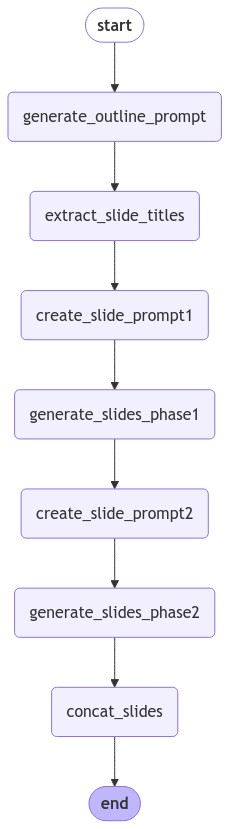

In [12]:
from typing import TypedDict, Annotated, Any
from langgraph.graph import StateGraph, START, END
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import HumanMessage
# from langgrpah.checkpoint.memory import MemorySaver
import operator


# Stage 정의
class State(TypedDict):
    topic: Annotated[str, "프레젠테이션 주제"]
    outline_prompt: Annotated[str, "프레젠테이션 개요 생성을 위해 실행할 프롬프트"]
    outline: Annotated[str, "프레젠테이션 개요"]
    slide_titles: Annotated[list, "슬라이드 타이틀 모음"]
    slide_prompt1: Annotated[str, "슬라이드 내용 생성을 위해 실행할 프롬프트"]
    slide_prompt2: Annotated[str, "슬라이드 내용 생성을 위해 실행할 프롬프트"]
    response_phase1: Annotated[list, "슬라이드 1-5장 내용"]
    response_phase2: Annotated[list, "슬라이드 6-10장 내용"]
    completed_content: Annotated[list, "최종 생성된 프레젠테이션 내용"]
    # aggregate: Annotated[list, operator.add]
    

# class ReturnNodeValue:
#     def __init__(self, node_secret: str):
#         self._value = node_secret

#     def __call__(self, state: State) -> Any:
#         print(f"Adding {self._value} to {state['aggregate']}")
#         return {"aggregate": [self._value]}


# 프레젠테이션 개요 생성 노드 정의
def generate_outline_prompt(state: State) -> State:
    # llm = get_llm_model(model_id="claude-3-haiku-20240307):
    prompt = state["outline_prompt"]
    response = converse_invoke(boto3_bedrock, model_id, prompt)    
    # print("response: \n", response)
    output_message = response['output']['message']['content'][0]['text']    
    # response = llm_sonnet.invoke([HumanMessage(content=prompt)])
    return State(outline=output_message)


# 생성한 프레젠테이션의 타이틀만 뽑아내는 노드 정의
def extract_slide_titles(state: State) -> State:
    # JSON 문자열을 Python 딕셔너리로 파싱
    outline = state["outline"]
    slide_titles = []
    data = json.loads(outline) if isinstance(outline, str) else outline
    # 메인 타이틀 출력
    # title = data['title']
    # 슬라이드 리스트를 순회하며 각 슬라이드의 제목 출력
    print("\n## Extract each slide titles in outline...")
    for slide in data['slides']:
        print(slide)
        slide_titles.append(slide['slide_title'])
    return State(slide_titles=slide_titles)


def create_slide_prompt1(state: State) -> State:
    print("\n## Generating prompt for creating the content of slides 1-5...\n")
    
    topic = state["topic"]
    outline = state["outline"]

    slide_prompt1 = slide_prompt_template.render(
        topic = topic,
        outline = outline,
        start_slide = 1,
        end_slide = 5
    )

    # print(slide_prompt1)
    return State(slide_prompt1=slide_prompt1)

def create_slide_prompt2(state: State) -> State:
    print("\n## Generating prompt for creating the content of slides 6-10...\n")
    
    topic = state["topic"]
    outline = state["outline"]

    slide_prompt2 = slide_prompt_template.render(
        topic = topic,
        outline = outline,
        start_slide = 6,
        end_slide = 10
    )

    # print(slide_prompt2)
    return State(slide_prompt2=slide_prompt2)

def generate_slides_phase1(state:State) -> State:
    slide_prompt1 = state["slide_prompt1"]
    print("\n## Generating content for slides 1-5...")
    print("\n## Prompt for slides 1-5...")
    print(slide_prompt1)
    
    response1 = converse_invoke(boto3_bedrock, model_id, slide_prompt1)

    output_message1 = response1['output']['message']['content'][0]['text']
    print("\n## Generated content for slides 1-5...") 
    print(output_message1)
    return State(response_phase1=output_message1)


def generate_slides_phase2(state:State) -> State:
    slide_prompt2 = state["slide_prompt2"]
    print("\n## Generating content for slides 6-10...")
    print("\n## Prompt for slides 6-10...")
    print(slide_prompt2)
    
    response2 = converse_invoke(boto3_bedrock, model_id, slide_prompt2)

    output_message2 = response2['output']['message']['content'][0]['text']
    print("\n## Generated content for slides 6-10...") 
    print(output_message2)
    return State(response_phase2=output_message2)

def concat_slides(state:State) -> State:
    response_phase1=state["response_phase1"]
    response_phase2=state["response_phase2"]
    merged_response = response_phase1 + response_phase2
    print("\n## Merged contents...")
    print(merged_response)
    return State(completed_content=merged_response)


# 그래프 정의
graph_builder = StateGraph(State)


# 노드, 엣지 추가 
graph_builder.add_node("generate_outline_prompt", generate_outline_prompt)
graph_builder.add_edge(START, "generate_outline_prompt")
graph_builder.add_node("extract_slide_titles", extract_slide_titles)
graph_builder.add_edge("generate_outline_prompt", "extract_slide_titles")

graph_builder.add_node("create_slide_prompt1", create_slide_prompt1)
graph_builder.add_edge("extract_slide_titles","create_slide_prompt1")

graph_builder.add_node("generate_slides_phase1", generate_slides_phase1)
graph_builder.add_edge("create_slide_prompt1", "generate_slides_phase1")


graph_builder.add_node("create_slide_prompt2", create_slide_prompt2)
graph_builder.add_node("generate_slides_phase2", generate_slides_phase2)
graph_builder.add_edge("generate_slides_phase1","create_slide_prompt2")
graph_builder.add_edge("create_slide_prompt2","generate_slides_phase2")


graph_builder.add_node("concat_slides", concat_slides)
graph_builder.add_edge("generate_slides_phase2", "concat_slides")
graph_builder.add_edge("concat_slides",END)


# 그래프 컴파일
graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


### 그래프를 실행할 함수 정의

In [13]:
def run_prompt(outline_prompt: str, topic: str, response_phase1: list, response_phase2: list, completed_content: list ):
    # inputs = {"prompt": prompt,"topic": topic}
    result = graph.invoke(State(outline_prompt=outline_prompt, topic=topic, response_phase1=response_phase1, response_phase2=response_phase1, completed_content=completed_content))
    # result = graph.invoke(input)
    return result["completed_content"]

### 그래프 실행

In [14]:
run_prompt(outline_prompt,TOPIC,[],[],[])


## Extract each slide titles in outline...
{'slide_number': '01', 'slide_title': '2024년 한국 부동산 시장: 동향과 전망'}
{'slide_number': '02', 'slide_title': '부동산 시장 개요 및 주요 이슈'}
{'slide_number': '03', 'slide_title': '주택 가격 동향 및 지역별 분석'}
{'slide_number': '04', 'slide_title': '임대 시장 현황 및 변화'}
{'slide_number': '05', 'slide_title': '정부 정책의 영향 및 규제 동향'}
{'slide_number': '06', 'slide_title': '금리 변동과 부동산 시장의 상관관계'}
{'slide_number': '07', 'slide_title': '부동산 투자 트렌드 및 새로운 기회'}
{'slide_number': '08', 'slide_title': '디지털 기술과 부동산 시장의 변화'}
{'slide_number': '09', 'slide_title': '2024년 부동산 시장 전망 및 결론'}
{'slide_number': '10', 'slide_title': 'Q&A 및 마무리'}

## Generating prompt for creating the content of slides 1-5...


## Generating content for slides 1-5...

## Prompt for slides 1-5...
You are an expert in creating impactful and professional PowerPoint presentations.
Your task is to create detailed content for a specific slide in 10-slide presentation in Korean, ensuring a logical flow and comprehensive coverag

'슬라이드 1: 2024년 한국 부동산 시장: 동향과 전망\n\n1. 슬라이드 제목: 2024년 한국 부동산 시장: 동향과 전망\n\n2. 주요 내용:\n• 2024년 부동산 시장의 핵심 동향 소개\n• 경제적, 정책적 요인이 부동산 시장에 미치는 영향\n• 향후 시장 전망 및 주요 고려사항\n\n3. 관련 데이터/예시:\n• 2023년 대비 2024년 부동산 가격 변동률\n• 주요 도시별 부동산 거래량 통계\n\n4. 시각화 제안:\n부동산 가격 지수와 거래량을 나타내는 복합 그래프\n\n5. 발표자 노트:\n본 프레젠테이션에서는 2024년 한국 부동산 시장의 주요 동향과 전망을 종합적으로 분석하고, 투자자와 정책 입안자들에게 유용한 인사이트를 제공할 것입니다.\n\n슬라이드 2: 부동산 시장 개요 및 주요 이슈\n\n1. 슬라이드 제목: 부동산 시장 개요 및 주요 이슈\n\n2. 주요 내용:\n• 2024년 부동산 시장의 전반적인 상황\n• 주택, 상업용 부동산, 토지 시장의 주요 트렌드\n• 부동산 시장에 영향을 미치는 핵심 이슈\n\n3. 관련 데이터/예시:\n• 부동산 유형별 시장 규모 및 성장률\n• 주요 이슈별 영향력 평가 지표\n\n4. 시각화 제안:\n부동산 유형별 시장 점유율을 나타내는 원형 차트와 주요 이슈의 영향력을 표현하는 히트맵\n\n5. 발표자 노트:\n이 슬라이드에서는 2024년 한국 부동산 시장의 전반적인 상황을 개괄하고, 각 부문별 주요 트렌드와 시장에 영향을 미치는 핵심 이슈들을 살펴볼 것입니다.\n\n슬라이드 3: 주택 가격 동향 및 지역별 분석\n\n1. 슬라이드 제목: 주택 가격 동향 및 지역별 분석\n\n2. 주요 내용:\n• 전국 주택 가격 동향 및 변동 요인\n• 수도권과 지방의 주택 시장 비교\n• 주요 도시별 주택 가격 변동 추이\n\n3. 관련 데이터/예시:\n• 지역별 주택 가격 지수 및 변동률\n• 주요 도시 아파트 평균 매매가 비교\n\n4. 시각화 제안:\n지도 위에 지역별 주택 가격 변동률을 색상으로 